# Joda HT

### Useful links

Spotify offers very clear documentation on how to work with their API. 
[Spotify API Documentation](https://developer.spotify.com/)

Console page lets you test making requests 
[API Console](https://developer.spotify.com/console/)

Quick guide on how to use the API: [Guide](https://stmorse.github.io/journal/spotify-api.html)

Config file includes the Client ID and Secret variables that should be kept private. These are needed in order to access the API.

If you want to run this notebook yourself: 
- you need a spotify account (free or premium, doesn't matter)
- sign in on https://developer.spotify.com/
- Go to Dashboard -> Create an app -> The app page will show the ID and Secret that you need to save to the config file

In [ ]:
!pip install pandas
!pip install matplotlib

import config
import requests
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Fetch and save data from the Spotify API

In [3]:
#Get client data from the config file
clientID = config.clientID
clientSEC = config.clientSEC

# Get the token with post request
tokenURL = 'https://accounts.spotify.com/api/token'

response = requests.post(tokenURL, {
    'grant_type': 'client_credentials',
    'client_id': clientID,
    'client_secret': clientSEC,
})

responseData = response.json()
token = responseData['access_token']

#Information for the get request
baseURL = 'https://api.spotify.com/v1/'
playlistID = '37i9dQZF1DX18jTM2l2fJY'

headers = {
    'Authorization': 'Bearer {token}'.format(token=token)
}

#Get the top 2021 playlist
top2021 = requests.get(baseURL + 'playlists/' + playlistID, headers=headers)
top2021 = top2021.json()
tracks = top2021["tracks"]["items"]

stuff = []

#Save song data from the get request
for item in tracks:
    #Get basic track info
    artist = item["track"]["artists"][0]["name"]
    track = item["track"]["name"]
    album = item["track"]["album"]["name"]
    popularity = item['track']['popularity']

    #Get audio features
    songID = item["track"]["id"]
    songData = requests.get(baseURL + 'audio-features?ids=' + songID, headers=headers)
    songData =  songData.json()
    features = songData["audio_features"][0]

    features.update({
    'artist': artist,
    'track': track, 
    'album': album,
    'popularity': popularity
    })

    stuff.append(features)

df = pd.DataFrame(stuff)
df.to_csv('data.csv')



### Clean the data

In [4]:
df = pd.read_csv('data.csv')

# Rename columns to be more descriptive
df.rename(columns={'tempo' : 'beats per minute', 'duration_ms' : 'duration(min)'}, inplace=True)

# Remove columns that are not needed
cols_to_remove=['Unnamed: 0', 'type', 'id', 'uri', 'track_href', 'analysis_url', 'time_signature']
data = df.drop(cols_to_remove,axis=1)

# Change track length from ms to minutes
for i in data['duration(min)']:
    length = i / 60000
    data['duration(min)'].replace({i : length}, inplace=True)

data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,beats per minute,duration(min),artist,track,album,popularity
0,0.561,0.431,10,-8.810,1,0.0578,0.76800,0.000014,0.1060,0.137,143.875,4.033550,Olivia Rodrigo,drivers license,SOUR,88
1,0.593,0.503,8,-6.725,0,0.2200,0.29300,0.000000,0.4050,0.710,178.781,2.295067,Lil Nas X,MONTERO (Call Me By Your Name),MONTERO,84
2,0.591,0.764,1,-5.484,1,0.0483,0.03830,0.000000,0.1030,0.478,169.928,2.363433,The Kid LAROI,STAY (with Justin Bieber),F*CK LOVE 3: OVER YOU,88
3,0.563,0.664,9,-5.044,1,0.1540,0.33500,0.000000,0.0849,0.688,166.928,2.969117,Olivia Rodrigo,good 4 u,SOUR,91
4,0.702,0.825,6,-3.787,0,0.0601,0.00883,0.000000,0.0674,0.915,102.977,3.384400,Dua Lipa,Levitating (feat. DaBaby),Future Nostalgia,85


### Data Visualization

In [7]:
data.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,beats per minute,duration(min),popularity
count,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000
mean,0.685720,0.64636,5.180000,-5.903920,0.620000,0.081374,0.253811,0.001606,0.182292,0.528884,121.083860,3.291473,80.54000
std,0.124987,0.14712,3.868713,2.036948,0.490314,0.057164,0.235345,0.006425,0.137799,0.232789,29.252206,0.578788,11.53028
min,0.380000,0.33900,0.000000,-11.639000,0.000000,0.028400,0.001460,0.000000,0.047600,0.082300,72.017000,2.213000,38.00000
25%,0.597750,0.54525,1.000000,-7.186250,0.000000,0.046125,0.040000,0.000000,0.093225,0.401500,98.655500,2.873342,80.00000
50%,0.714500,0.65650,5.500000,-5.485500,1.000000,0.063150,0.196000,0.000000,0.115000,0.518000,120.516500,3.311875,83.00000
75%,0.774500,0.76475,8.000000,-4.258500,1.000000,0.094300,0.405500,0.000024,0.246500,0.706250,138.532000,3.593283,87.00000
max,0.903000,0.89300,11.000000,-2.810000,1.000000,0.286000,0.827000,0.038200,0.688000,0.958000,180.917000,4.785333,91.00000


<AxesSubplot:title={'center':'Amount of tracks each artist has'}, xlabel='artist'>

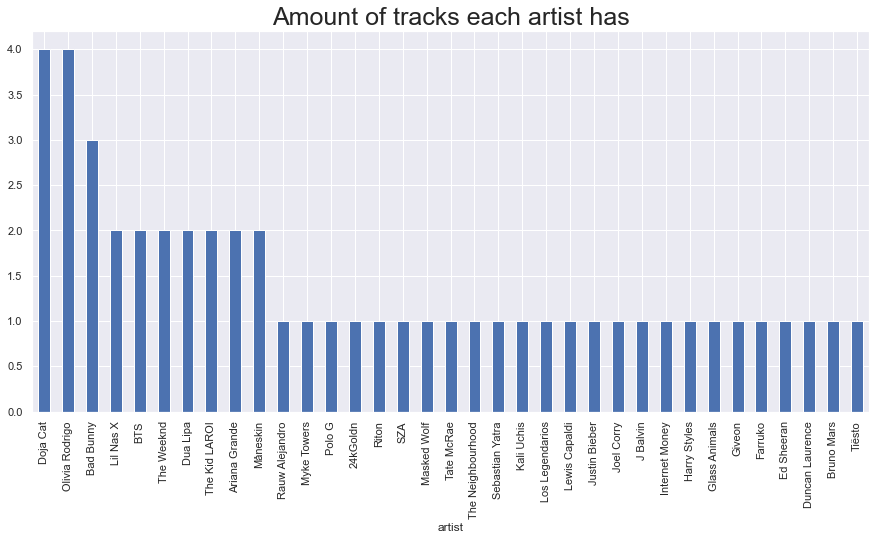

In [46]:
plt.figure(figsize=(15,7))
plt.title("Amount of tracks each artist has", fontsize=25)

data.groupby('artist')['track'].agg(len).sort_values(ascending = False).plot(kind = 'bar')

#data.plot.scatter(x = 'danceability', y = 'popularity')

<AxesSubplot:title={'center':'Heatmap'}>

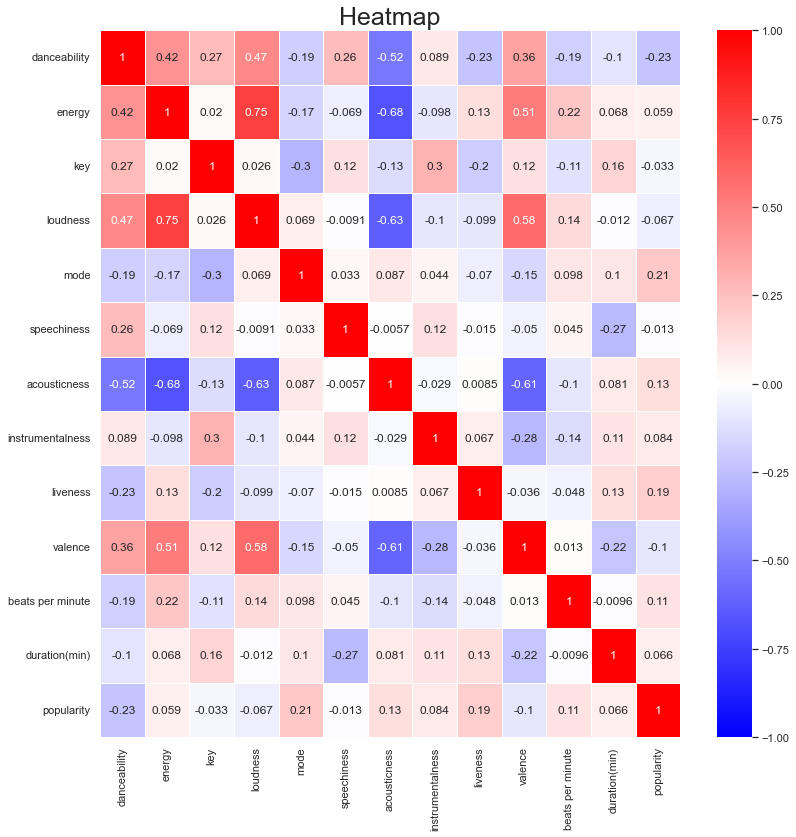

In [91]:
plt.figure(figsize=(13,13))
plt.title('Heatmap', fontsize=25)

sns.heatmap(data.corr(method='pearson'),
            annot=True,
            vmin=-1,
            vmax=1,
            #center=1,
            linewidths=.5,
            cmap='bwr'
)

array([[<AxesSubplot:xlabel='danceability', ylabel='danceability'>,
        <AxesSubplot:xlabel='energy', ylabel='danceability'>,
        <AxesSubplot:xlabel='key', ylabel='danceability'>,
        <AxesSubplot:xlabel='loudness', ylabel='danceability'>,
        <AxesSubplot:xlabel='mode', ylabel='danceability'>,
        <AxesSubplot:xlabel='speechiness', ylabel='danceability'>,
        <AxesSubplot:xlabel='acousticness', ylabel='danceability'>,
        <AxesSubplot:xlabel='instrumentalness', ylabel='danceability'>,
        <AxesSubplot:xlabel='liveness', ylabel='danceability'>,
        <AxesSubplot:xlabel='valence', ylabel='danceability'>,
        <AxesSubplot:xlabel='beats per minute', ylabel='danceability'>,
        <AxesSubplot:xlabel='duration(min)', ylabel='danceability'>,
        <AxesSubplot:xlabel='popularity', ylabel='danceability'>],
       [<AxesSubplot:xlabel='danceability', ylabel='energy'>,
        <AxesSubplot:xlabel='energy', ylabel='energy'>,
        <AxesSubplot:xlabel

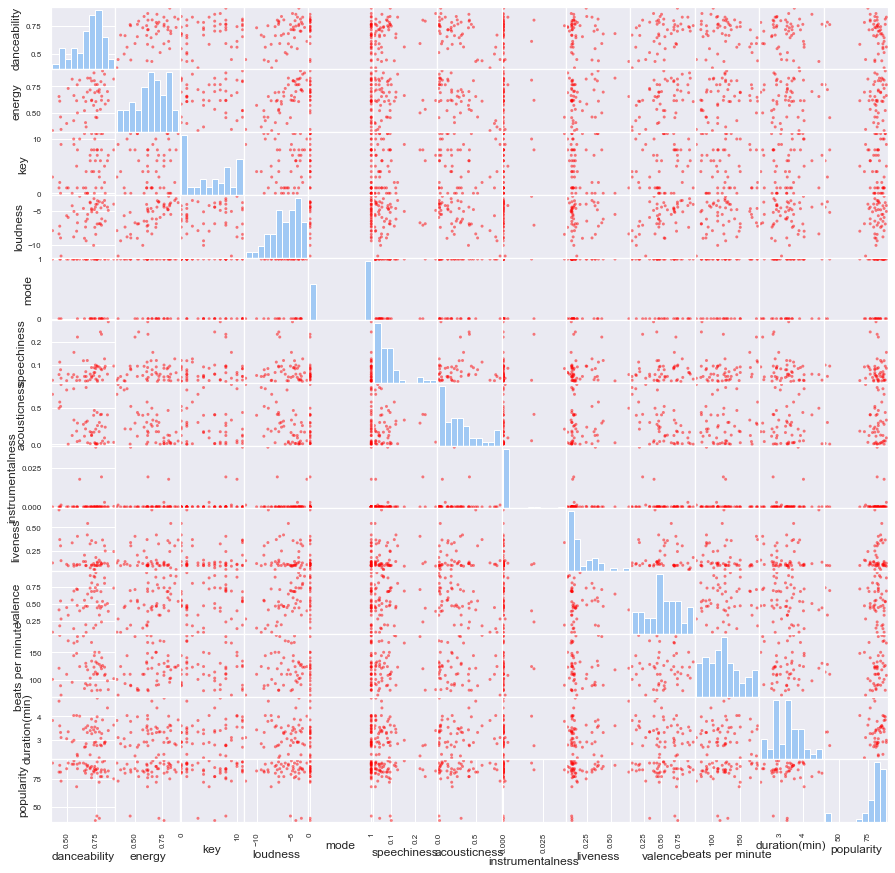

In [100]:
cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
        'instrumentalness', 'liveness', 'valence', 'beats per minute', 'duration(min)', 'popularity']

scatter_matrix(data[cols], figsize=(15,15), c='red')